You can run this notebook in Google Colab by right-clicking on the badge below, and opening the link in a new tab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KieranLitschel/XSWEM/blob/main/notebooks/local_explain_most_salient_words.ipynb)

# Introduction

In this notebook we demonstrate the local_explain_most_salient_words method using the [ag_news](https://huggingface.co/datasets/viewer/?dataset=ag_news) datasets. As the name suggests, this method gives a local explanation from the trained model for an input sentence. It does this by returning the words the model shortlists (the learnt most salient words) from the input sentence in order to make a prediction.

First lets explain how it works. We'll explain this using the diagram below. It shows how our model processes and makes a prediction for a sample from our test set. The dotted line shows that we take the output of the embedding block to determine the most salient words. In the next two sections we'll explain this diagram in more detail.


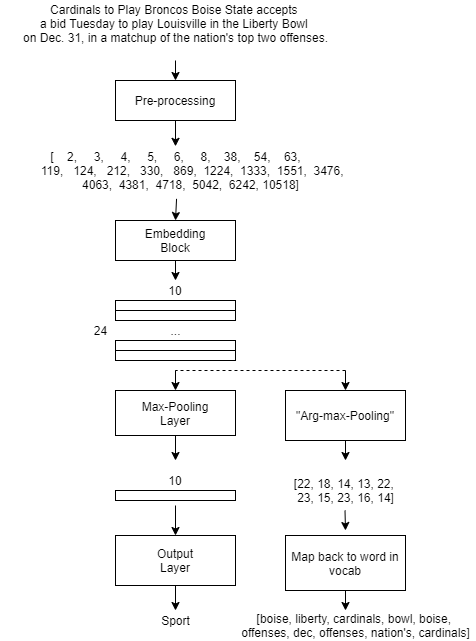

## How we make a prediction for the sample

First we pre-process the sample outside of the model, tokenizing the sample and only keeping the unique tokens (SWEM-max is invariant to word order and frequency). The tokenized sample is input into the model.

The embedding block maps the tokens to their corresponding word embedding vectors (henceforth we abreviate these as word embeddings). The block also adapts embeddings if this is specified in the models constructor. The output of the embedding block is a matrix. There is a row in the matrix for each word embedding. In our case the matrix has 24 rows as we have 24 tokens in our pre-processed sample. The number of columns is equal to the embedding_size 
specified in the model constructor. In our example the embedding_size is 10, so we have 10 columns.

We apply a max-pooling layer to the columns of the embeddings matrix. This reduces the matrix to a feature vector with embedding_size components. As described by Shen et al. in the original paper, the max-pooling layer extracts the most salient features from the word embeddings. 

We then apply the output layer to the feature vector to make a prediction for the sample. As this is a multiclass classification problem, with 4 possible classes, our output layer is a dense layer with 4 units and a softmax activation function. In the case of this sample, the model correctly predicts the most likely class as "Sport".

## How we reduce the sample to the most salient words

Our local_explain_most_salient_words method takes as input a tokenized sample. We then apply the embedding block to the tokens to produce the embedding matrix.

But instead of applying max-pooling to the columns of the embeddings matrix, we take the argmax of the columns. This gives us the position of the largest value in each column. This is the output of the "arg-max-pooling" layer in the diagram below. We can then reverse lookup the word that corresponds to each position in the matrix, and map the positions back to words in the models vocabulary. These words are the output of our local explain method.

The max-pooling layer extracts the most salient features of the input sequence. For our model, each of these features can be traced back to a single word, which is what we do for this local explain method. The model has learnt that these words are the most salient for predicting the class of the input sample.


# Example Code

Install XSWEM and [Hugging Face datasets](https://github.com/huggingface/datasets).

In [ ]:
!pip install xswem
!pip install datasets

Make this notebook deterministic.

In [2]:
RANDOM_SEED = 0

# Python RNG
import random
random.seed(RANDOM_SEED)

# Numpy RNG
import numpy as np
np.random.seed(RANDOM_SEED)

# TF RNG
import tensorflow as tf
from tensorflow.python.framework import random_seed
random_seed.set_seed(RANDOM_SEED)

Import the necessary modules.

In [3]:
from xswem.model import XSWEM
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset

Load and shuffle the dataset. We keep 10% of the training set for validation.

In [4]:
ag_news = load_dataset('ag_news')
ag_news = ag_news.shuffle({"train":RANDOM_SEED,"test":RANDOM_SEED})
ag_news["train"] = ag_news["train"].train_test_split(test_size=0.1,seed=RANDOM_SEED)
ag_news_train, ag_news_valid = ag_news["train"]["train"], ag_news["train"]["test"]
X, y = ag_news_train["text"], ag_news_train["label"]
X_valid, y_valid = ag_news_valid["text"], ag_news_valid["label"]
ag_news_test = ag_news["test"]
X_test, y_test = ag_news_test["text"], ag_news_test["label"]

Using custom data configuration default


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


Build the tokenizer.

In [5]:
NUM_WORDS = 16000
FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789'
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="UNK", filters=FILTERS)
tokenizer.fit_on_texts(X)
vocab_map = {i+1: tokenizer.index_word[i+1] for i in range(NUM_WORDS)}
output_map = {0: "World", 1: "Sport", 2: "Business", 3: "Tech"}

Build the dataset pipeline.

In [6]:
BATCH_SIZE = 32
NUM_LABELS = len(output_map)

train_dataset = Dataset.from_tensor_slices((X,y))
valid_dataset = Dataset.from_tensor_slices((X_valid,y_valid))
test_dataset = Dataset.from_tensor_slices((X_test,y_test))

# shuffle the train datasets
train_dataset = train_dataset.shuffle(BATCH_SIZE*2)

# tokenize the text and one hot encode the labels
# we only keep unique tokens as XSWEM is invariant to token frequency and order
tokenize = lambda text, label: (tf.py_function(lambda text: np.unique(tokenizer.texts_to_sequences([str(text.numpy())])[0]), inp=[text], Tout=tf.int32), tf.one_hot(label,NUM_LABELS))
train_dataset = train_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)

# pre-fetch so that GPU spends less time waiting
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# padded batch allows us to handle varying sentence lengths
train_dataset = train_dataset.padded_batch(BATCH_SIZE,padded_shapes=([None],[NUM_LABELS]))
valid_dataset = valid_dataset.padded_batch(BATCH_SIZE,padded_shapes=([None],[NUM_LABELS]))
test_dataset = test_dataset.padded_batch(1,padded_shapes=([None],[NUM_LABELS]))

Build XSWEM model. In this notebook we use an embedding_size of 10 so that at maximum our local explain method will return 10 words.

In [7]:
model = XSWEM(10, "softmax", vocab_map, output_map, mask_zero=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-1)
model.compile(optimizer, loss="categorical_crossentropy", metrics="accuracy")

Train XSWEM model.

In [8]:
model.fit(train_dataset, validation_data=valid_dataset, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', restore_best_weights=True)], epochs=20)

Epoch 1/20
3375/3375 [==============================] - 61s 17ms/step - loss: 0.6857 - accuracy: 0.7461 - val_loss: 0.3508 - val_accuracy: 0.8791
Epoch 2/20
3375/3375 [==============================] - 59s 17ms/step - loss: 0.3230 - accuracy: 0.8909 - val_loss: 0.3185 - val_accuracy: 0.8917
Epoch 3/20
3375/3375 [==============================] - 58s 17ms/step - loss: 0.2685 - accuracy: 0.9083 - val_loss: 0.3102 - val_accuracy: 0.8949
Epoch 4/20
3375/3375 [==============================] - 58s 17ms/step - loss: 0.2362 - accuracy: 0.9197 - val_loss: 0.3163 - val_accuracy: 0.8960
Epoch 5/20
3375/3375 [==============================] - 58s 17ms/step - loss: 0.2135 - accuracy: 0.9275 - val_loss: 0.3251 - val_accuracy: 0.8957


Test XSWEM model.

In [9]:
model.evaluate(test_dataset)

7600/7600 [==============================] - 17s 2ms/step - loss: 0.3453 - accuracy: 0.8892


[0.34532564878463745, 0.8892105221748352]

In [10]:
test_preprocess = list(test_dataset.take(10))

def show_example(sample_no):
    print(X_test[sample_no])
    sample_input = test_preprocess[sample_no][0]
    predicted_label = output_map[np.argmax(model.predict(sample_input))]
    actual_label = output_map[y_test[sample_no]]
    print("Predicted label: {0}\nActual label: {1}".format(predicted_label, actual_label))
    print("Most salient words: ", model.local_explain_most_salient_words(sample_input.numpy()[0]))

Below we show the output of local_explain_most_salient_words for the first 10 sentences in the test set. In each cell the first line is the raw sentence before pre-processing, the second line is the label predicted by the model, the third line is the true label, and the fourth line is the most salient words extracted using our method.

To see the most salient words by index you can specify "by_index=True" as a keyword argument for the local_explain method. If the argument is not specified, by_index is False, meaning we show the unique most salient words sorted alphabetically.

In [11]:
show_example(0)

McTeer: Lonesome Dove to be an Aggie NEW YORK (CNN/Money) - A New Economy champion, a lover of the Texas picker poets who write lovesick country songs...and, oh, by the way, a member of the Federal Reserve system for 36 years.
Predicted label: Business
Actual label: Business
Most salient words:  ['cnn' 'economy' 'federal' 'lover' 'reserve' 'write']


In [12]:
show_example(1)

Peru Gov't: Police Killed in Self-Defense Peru's interior minister said Wednesday that police acted in self-defense when they killed three coca farmers who were part of a group that hurled rocks and tried to burn a police lieutenant alive to protest U.S.-backed eradication of their cocaine producing crop.
Predicted label: World
Actual label: World
Most salient words:  ['acted' 'coca' 'cocaine' 'crop' "gov't" 'killed' 'minister' 'protest']


In [13]:
show_example(2)

SpaceShipOne Rolls Toward Victory MOJAVE, California -- A Southern California aerospace team took a big step toward capturing the \$10 million Ansari X Prize Wednesday, but not without surviving a scary moment when the pilot found himself in a rapid spin as he roared across the threshold 
Predicted label: Tech
Actual label: Tech
Most salient words:  ['ansari' 'himself' 'mojave' 'threshold' 'x']


In [14]:
show_example(3)

Cards unfazed by Series deficit Monday #39;s workout at Busch Stadium contained a few more St. Louis Cardinals than you #39;d expect considering it was optional, but you could understand why they #39;d want to 
Predicted label: Sport
Actual label: Sport
Most salient words:  ['cardinals' 'contained' 'deficit' 'optional' 'unfazed' 'workout']


In [15]:
show_example(4)

Spawn of X Prize on Horizon Innovators take note: The folks behind the X Prize vow there will soon be more competitions in several disciplines. Also: The da Vinci team presses ahead in Canada.... Rubicon team plans another launch attempt. By Dan Brekke.
Predicted label: Tech
Actual label: Tech
Most salient words:  ['canada' 'da' 'dan' 'horizon' 'launch' 'presses' 'vinci' 'vow' 'x']


In [16]:
show_example(5)

Myskina, Kuznetsov to Play in Fed Cup (AP) AP - Anastasia Myskina and Svetlana Kuznetsova will lead Russia's Fed Cup team when it plays Austria in this month's semifinals. Defending champion France will feature Amelie Mauresmo and Mary Pierce in the other semifinal against Spain, which has won this event five times.
Predicted label: Sport
Actual label: Sport
Most salient words:  ['champion' 'cup' 'feature' 'fed' "month's" 'other' "russia's"]


In [20]:
show_example(6)

Prosecutor seeks 8 years in jail for Berlusconi  MILAN -- An Italian prosecutor asked a court yesterday to sentence Silvio Berlusconi to eight years in jail for bribing judges as the prime minister's four-year corruption trial reached its closing stages.
Predicted label: World
Actual label: World
Most salient words:  ['berlusconi' 'corruption' 'jail' 'milan' 'sentence' 'stages' 'trial']


In [17]:
show_example(7)

Intel drops prices on computer chips SAN FRANCISCO - Intel Corp. has cut prices on its computer chips by as much as 35 percent, though analysts on Monday said the cuts were probably unrelated to swelling inventories of the world #39;s largest chip maker.
Predicted label: Business
Actual label: Tech
Most salient words:  ['chip' 'computer' 'corp' 'intel' 'inventories' 'prices' 'swelling']


In [18]:
show_example(8)

Cardinals to Play Broncos Boise State accepts a bid Tuesday to play Louisville in the Liberty Bowl on Dec. 31, in a matchup of the nation's top two offenses.
Predicted label: Sport
Actual label: Sport
Most salient words:  ['boise' 'bowl' 'cardinals' 'liberty' "nation's" 'offenses']


In [19]:
show_example(9)

Dollar Stabilizes Above Recent Lows (Reuters) Reuters - The dollar edged up against the yen and\steadied against the euro on Friday, but kept within sight of\multi-month lows hit this week on worries about the U.S.\economy and its ability to attract global investors.
Predicted label: Business
Actual label: Business
Most salient words:  ['ability' 'attract' 'economy' 'euro' 'multi' 'sight' 'u' 'worries' 'yen']
